# Utilizing NLP techniques in analyzation of text complaints

## Conception
**Choosing a dataset**

The first step would be to choose an appropriate dataset. We are looking for datasets comprising complaints regarding decisions made by the local municipality, or other appropriate dataset from other domains, e.g., customer complaints, online comments, product reviews, etc. In this case, Kaggle was used and the [Spotify App Reviews](https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022/data) dataset was chosen which falls within the "product reviews" domain.

The main goal of this project is to determine the most **pressing issues** comprising the dataset. In this case, to only process reviews containing negative feedback, the *Spotify App Reviews* will be filtered to only include those with `< 3.0` ratings. Some sentiment analysis will also be done to further filter out potentially positive reviews.
<br><br>

**Achieving "clean text"**

To prepare the data for further NLP tasks, the following steps are to be performed to preprocess the texts.


*   Elimination of stopwords
*   Removing punctuations
*   Lowercasing
*   Tokenization
*   Lemmatization/Stemming
<br><br>

**Vectorization**

Two vectorization techniques that can be used with the subsequent steps are the following:
1. TF
    > a way to convert a given set of strings into a frequency representation.
2. TF-IDF or Term Frequency–Inverse Document Frequency
    > This is a statistic that is based on the frequency of a word in the corpus but it also provides a numerical representation of how important a word is for statistical analysis.
<br><br>


**Extracting Topics**

After vectorization, two techniques will be used for topic extraction and the results will be compared to determine which one performs better for this specific project.

1. Latent Dirichlet Allocation (LDA)
> LDA looks at a document to determine a set of topics that are likely to have generated that collection of words

2. Non-Negative Matrix Factorization (NMF)
> Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on.


## Development

### Downloading the dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d mfaaris/spotify-app-reviews-2022
!unzip spotify-app-reviews-2022.zip
!rm spotify-app-reviews-2022.zip

 74% 3.00M/4.04M [00:00<00:00, 5.52MB/s]
100% 4.04M/4.04M [00:00<00:00, 6.07MB/s]
Archive:  spotify-app-reviews-2022.zip
  inflating: reviews.csv             


In [ ]:
!pip install keybert

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import time
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob
from tqdm import tqdm

tqdm.pandas()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
df = pd.read_csv('reviews.csv')

In [ ]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


### Preparing/Preprocessing the Dataset

Only keep the `Review` and `Rating` column from the original dataframe

In [ ]:
df = df[['Review', 'Rating']].copy()

The dataset contains all the app reviews, even positive ones. To filter the positive reviews out, we will only include those reviews with ratings of **3** stars or less.

In [ ]:
df = df.loc[df['Rating'] < 3.0]

Some rows might still contain positive reviews, to eliminate as much as possible, we need to take a step further. We will use sentiment analysis to remove reviews with a potentially positive tone.

In [ ]:
df['Sentiment'] = df['Review'].progress_apply(lambda text: TextBlob(str(text)).sentiment.polarity)
df = df.loc[df['Sentiment'] < 0.2]

100%|██████████| 24771/24771 [00:08<00:00, 2796.34it/s]


In [ ]:
df = df.reset_index(drop=True)
df

,Review,Rating,Sentiment
0,Really buggy and terrible to use as of recently,1,-0.266667
1,Dear Spotify why do I get songs that I didn't ...,1,0.000000
2,"I'm deleting this app, for the following reaso...",1,0.178571
3,"Love Spotify, and usually this app is the best...",2,0.144444
4,Can't play Spotify when on WiFi,1,0.000000
...,...,...,...
20101,Keeps putting songs I've hidden in my suggeste...,1,0.086667
20102,One day I was able to switch between songs and...,1,-0.025000
20103,It was my favourite app. I feel sorry for arti...,1,-0.251240
20104,Back to one frkng star. First of all there's t...,1,-0.024570


Lemmatization, eliminating stopwords, lowercasing, and removing punctuations

In [ ]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm.auto import tqdm

lemmatizer = WordNetLemmatizer()
non_alpha_numeric_pattern = re.compile(r'\W+')
english_stopwords = set(stopwords.words('english'))

def clean_text(text):
    tokens = non_alpha_numeric_pattern.sub(' ', text.lower()).split()
    meaningful_words = [lemmatizer.lemmatize(token) for token in tokens if token not in english_stopwords]
    cleaned_text = ' '.join(meaningful_words).strip()
    return cleaned_text

df['Processed_Review'] = [clean_text(review) for review in tqdm(df['Review'])]


  0%|          | 0/20106 [00:00<?, ?it/s]

Remove rows with empty `Processed_Review`

In [ ]:
df['Processed_Review'].replace('', np.nan, inplace=True)
df.dropna(subset=['Processed_Review'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Review,Rating,Sentiment,Processed_Review
0,Really buggy and terrible to use as of recently,1,-0.266667,really buggy terrible use recently
1,Dear Spotify why do I get songs that I didn't ...,1,0.000000,dear spotify get song put playlist shuffle play
2,"I'm deleting this app, for the following reaso...",1,0.178571,deleting app following reason app failing busi...
3,"Love Spotify, and usually this app is the best...",2,0.144444,love spotify usually app best others stated co...
4,Can't play Spotify when on WiFi,1,0.000000,play spotify wifi
...,...,...,...,...
20101,Keeps putting songs I've hidden in my suggeste...,1,0.086667,keep putting song hidden suggested song listen...
20102,One day I was able to switch between songs and...,1,-0.025000,one day able switch song fast forward go back ...
20103,It was my favourite app. I feel sorry for arti...,1,-0.251240,favourite app feel sorry artist lost lot reven...
20104,Back to one frkng star. First of all there's t...,1,-0.024570,back one frkng star first spotify trying play ...


### Helper functions

Used for displaying and plotting topics after NLP

In [ ]:
def display_topics(model, feature_names):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 8), sharex=True)
    axes = axes.flatten()
    for n, topic in enumerate(model.components_):
        print(f'Topic {n + 1}: {" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])}')
        top_features_ind = topic.argsort()[-10:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[n]
        ax.barh(top_features, weights, height=0.5)
        ax.set_title(f'Topic {n + 1}', fontdict={'fontsize': 12})
        ax.tick_params(axis='both', which='major', labelsize=8)
        fig.suptitle('Top words for each topic', fontsize=12)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
from keybert import KeyBERT

def display_topics_with_coherence(model, feature_names, documents, n_top_words=10):
    kw_model = KeyBERT(model='all-MiniLM-L6-v2')
    coherence_scores = []

    topics_top_words = [[' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])] for topic in model.components_]

    for topic_idx, top_words in enumerate(topics_top_words):
        print(f'Topic {topic_idx + 1}: {" ".join(top_words)}')

        doc_coherence_scores = []
        for doc in tqdm(documents):
            extracted_keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 3), stop_words='english', top_n=5)
            scores = [score for word, score in extracted_keywords if word in top_words[0]]
            if scores:
                doc_coherence_scores.append(sum(scores) / len(scores))

        avg_coherence_score = sum(doc_coherence_scores) / len(doc_coherence_scores) if doc_coherence_scores else 0
        coherence_scores.append(avg_coherence_score)
        print(f'Average Coherence Score for Topic {topic_idx + 1}: {avg_coherence_score:.4f}\n')

### Latent Dirichlet Allocation (LDA)

Use TF

In [ ]:
lda_vect = CountVectorizer(min_df=0.01, stop_words='english')
lda_m = lda_vect.fit_transform(df['Processed_Review'])
lda_feature_names = lda_vect.get_feature_names_out()

Fit the LDA Model

In [ ]:
start = time.time()
lda = LatentDirichletAllocation(n_components=10, learning_method='online', learning_offset=50., random_state=0).fit(lda_m)
end = time.time()
print(f'Finished after {end-start}s')

Finished after 25.932361364364624s


### Non-Negative Matrix Factorization (NMF)

Use TF-IDF

In [ ]:
nmf_vect = TfidfVectorizer(min_df=0.01, stop_words='english')
nmf_m = nmf_vect.fit_transform(df['Processed_Review'])
nmf_feature_names = nmf_vect.get_feature_names_out()

Fit the NMF Model

In [ ]:
start = time.time()
nmf = NMF(n_components=10, random_state=1, alpha_W=0.00005, alpha_H=0.00005).fit(nmf_m)
end = time.time()
print(f'Finished after {end-start}s')

Finished after 1.6106288433074951s


## Finalization

#### LDA Results


Topic 1: day app change spotify anymore version good use able fixed
Topic 2: music downloaded offline spotify fix download app premium play issue
Topic 3: account log feature working app spotify logged tried login let
Topic 4: ad song option minute music 30 app free 10 add
Topic 5: playing app stop play music song pause randomly start bar
Topic 6: app spotify time problem like worst music using fix used
Topic 7: premium pay service subscription paying money month got spotify track
Topic 8: song play playlist listen want like app skip shuffle music
Topic 9: update app new podcasts bug spotify frustrating worse really terrible
Topic 10: app work phone open internet device time crash connection crashing


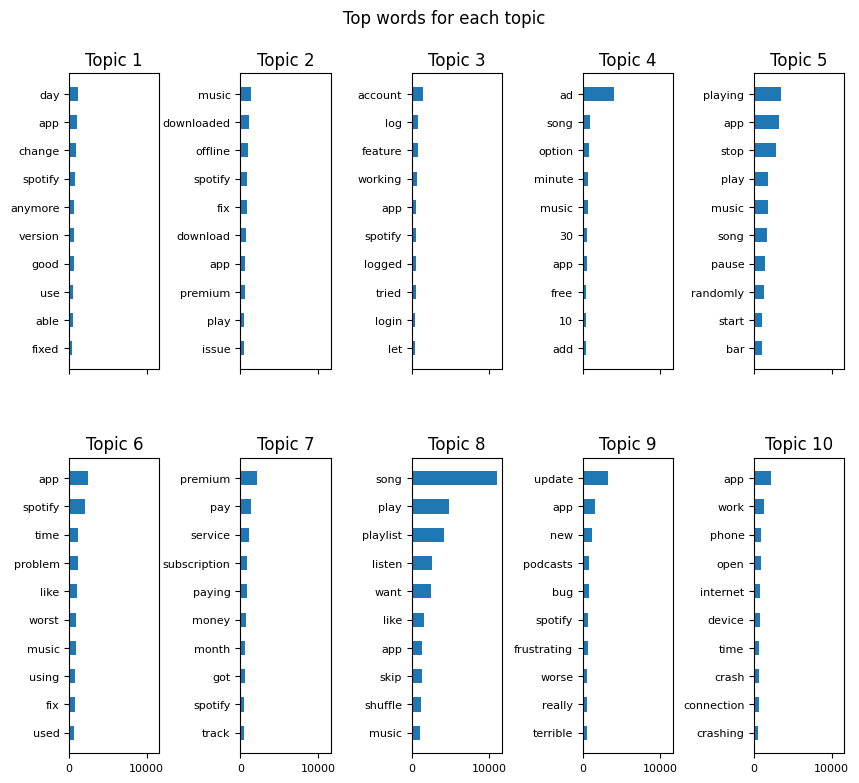

In [ ]:
display_topics(lda, lda_feature_names)

#### NMF Results

Topic 1: song listen want like skip random hate choose hear search
Topic 2: playing stop randomly pause bar control start phone close screen
Topic 3: ad 30 minute annoying free min listening irritating worst premium
Topic 4: spotify fix use phone problem like year issue using really
Topic 5: music listen like want youtube downloaded listening offline download service
Topic 6: play button shuffle song random pause want list fix try
Topic 7: app time work open crash worst phone constantly use crashing
Topic 8: update new recent fix latest bug control issue bar suck
Topic 9: playlist add shuffle make adding annoying random added remove feature
Topic 10: premium account log pay logged paying subscription month offline email


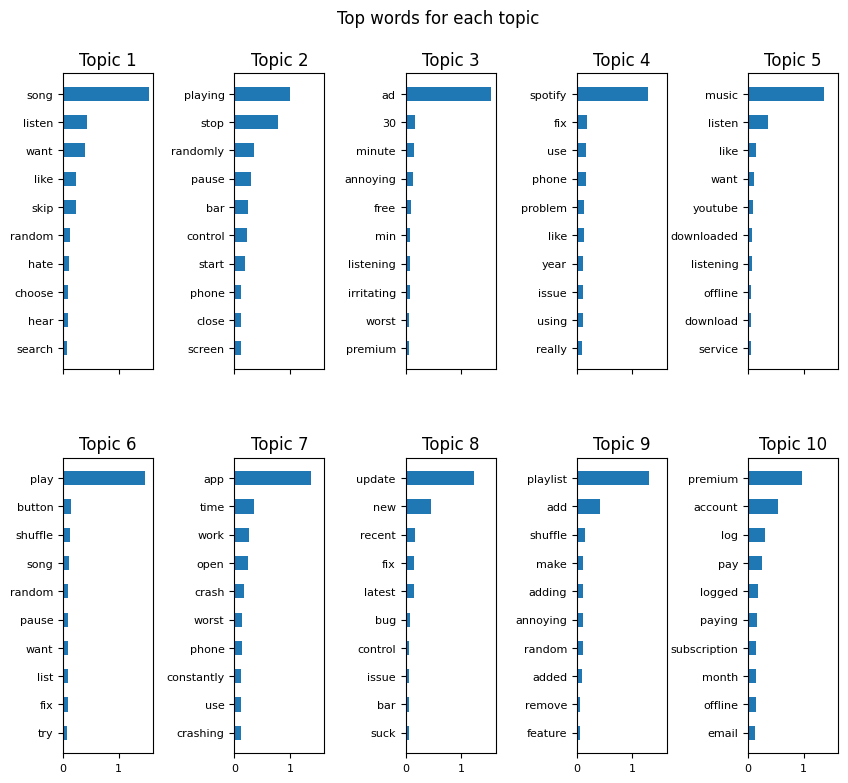

In [ ]:
display_topics(nmf, nmf_feature_names)

#### Results with coherence

In [ ]:
documents = df['Processed_Review'].tolist()

display_topics_with_coherence(lda, lda_feature_names, documents, n_top_words=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Topic 1: day app change spotify anymore version good use able fixed


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 1: 0.5953

Topic 2: music downloaded offline spotify fix download app premium play issue


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 2: 0.5962

Topic 3: account log feature working app spotify logged tried login let


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 3: 0.5960

Topic 4: ad song option minute music 30 app free 10 add


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 4: 0.5537

Topic 5: playing app stop play music song pause randomly start bar


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 5: 0.5173

Topic 6: app spotify time problem like worst music using fix used


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 6: 0.5935

Topic 7: premium pay service subscription paying money month got spotify track


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 7: 0.6023

Topic 8: song play playlist listen want like app skip shuffle music


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 8: 0.5896

Topic 9: update app new podcasts bug spotify frustrating worse really terrible


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 9: 0.5937

Topic 10: app work phone open internet device time crash connection crashing


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 10: 0.5622



In [ ]:
display_topics_with_coherence(nmf, nmf_feature_names, documents, n_top_words=10)

Topic 1: song listen want like skip random hate choose hear search


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 1: 0.5191

Topic 2: playing stop randomly pause bar control start phone close screen


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 2: 0.5050

Topic 3: ad 30 minute annoying free min listening irritating worst premium


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 3: 0.5756

Topic 4: spotify fix use phone problem like year issue using really


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 4: 0.6037

Topic 5: music listen like want youtube downloaded listening offline download service


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 5: 0.5732

Topic 6: play button shuffle song random pause want list fix try


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 6: 0.5855

Topic 7: app time work open crash worst phone constantly use crashing


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 7: 0.5635

Topic 8: update new recent fix latest bug control issue bar suck


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 8: 0.5169

Topic 9: playlist add shuffle make adding annoying random added remove feature


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 9: 0.6068

Topic 10: premium account log pay logged paying subscription month offline email


  0%|          | 0/20106 [00:00<?, ?it/s]

Average Coherence Score for Topic 10: 0.5906

